<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *AIB / SECTION 2 / SPRINT 2 / NOTE 1*

# 📝 Assignment
---

# Decision Trees(결정트리)

## 캐글 인클래스(InClass) Competitions

### 1) 대회 참여(Join) 및 데이터셋 준비

- [캐글 계정을 만드세요](https://www.kaggle.com/), 공유된 인클래스 대회 url을 통해 이동한 후 대회에 참여하세요.
- H1N1 데이터를 훈련/검증/테스트 셋으로 나누어 준비하세요
- **(Urclass Quiz) 훈련데이터셋을 사용해 H1N1 타겟으로 기준모델을 설정하세요. 기준모델의 정확도를 제출하세요.**
    1. 0.24
    2. 0.50
    3. 0.76
    4. 1


In [1]:
!pip install -U pandas-profiling
!pip install --upgrade category_encoders

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
### 이곳에서 과제를 진행해 주세요 ###

import pandas as pd
from sklearn.model_selection import train_test_split

target = 'vacc_h1n1_f'

train_origin = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/prediction-of-h1n1-vaccination/train.csv')
train_labels =  pd.read_csv('/content/drive/MyDrive/Colab Notebooks/prediction-of-h1n1-vaccination/train_labels.csv')[target]
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/prediction-of-h1n1-vaccination/test.csv')

train_data = pd.merge(train_origin,train_labels,left_index=True, right_index=True)
train, val = train_test_split(train_data, train_size=0.80, test_size=0.20, stratify=train_data[target], random_state=2)
train.shape, val.shape, test.shape

((33723, 39), (8431, 39), (28104, 38))

In [4]:
from sklearn.metrics import accuracy_score
pred = [train[target].mode()] * len(train[target])
accuracy_score(train[target],pred)

0.7609346736648578

### 2) 데이터 EDA 및 특성공학 수행
- profiling을 사용하여 데이터를 살펴보고, missing value, zeros, cardinarity 등을 확인하여 처리하세요.
- 본인만의 특성공학을 수행하세요.


In [5]:
### 이곳에서 과제를 진행해 주세요 ###
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
train.describe(include='object').T.sort_values(by='unique')                      # train 데이터에서 타입이 오브젝트인 열을 골라 개요를 만든 뒤 전치하고 unique(고유값의 개수)를 기준으로 정렬

,count,unique,top,freq
employment_status,25466,3,Employed,13722
census_msa,33723,3,"MSA, Not Principle City",15202
opinion_h1n1_vacc_effective,26637,6,Somewhat Effective,11710
opinion_h1n1_risk,26602,6,Somewhat Low,9980
opinion_h1n1_sick_from_vacc,26568,6,Not Very Worried,9229
opinion_seas_vacc_effective,26519,6,Somewhat Effective,11571
opinion_seas_risk,26466,6,Somewhat Low,9057
opinion_seas_sick_from_vacc,26413,6,Not At All Worried,11813
agegrp,33723,7,65+ Years,6821
employment_industry,13714,23,Health Care and Social Assistance Industries,2451


In [7]:
import numpy as np

def engineer(df):
    # 높은 카디널리티를 가지는 특성을 제거
    selected_cols = df.select_dtypes(include=['number', 'object']) # 데이터 타입이 number, object 인 열을 선택
    labels = selected_cols.nunique() # 각 열의 고유값의 개수를 labels에 저장
    selected_features = labels[labels <= 30].index.tolist() # labels 값이 30 이하인 인덱스로 리스트 생성
    df = df[selected_features] # 리스트에 포함된 열을 추출
    
    # 새로운 특성 생성 - 행동 점수
    behaviorals = [col for col in df.columns if 'behavioral' in col] # 데이터의 칼럼 중 'behavioral'을 포함하는 칼럼의 이름을 리스트로 생성
    df['behaviorals'] = df[behaviorals].sum(axis=1) # 리스트에 포함된 열을 추출하여 합계 한 후 새로운 칼럼으로 생성
    
    # 관련성이 적은 특성 삭제 - 고용 관련, 시즌 백신 관련
    dels = [col for col in df.columns if ('employment' in col or 'seas' in col)]
    df.drop(columns=dels, inplace=True)

    # 결측치 대체
    df.fillna(method='ffill', inplace=True) # 결측치가 많아 각 항목의 비율 유지를 위해 최빈값 대체 보단 ffill 또는 bfill 사용
    df.fillna(method='bfill', inplace=True) # 첫 행에 결측치가 있을 경우 다음 행의 값으로 대체   
    return df

train = engineer(train)
val = engineer(val)
test = engineer(test)

In [8]:
X_train = train.drop(target, axis=1)
y_train = train[target]
X_val = val.drop(target, axis=1)
y_val = val[target]
X_test = test


### 3) 모델링 수행
- 결정트리를 학습시킵니다. 하이퍼파라미터를 수정하여 성능을 높여보세요. 과적합을 주의하세요!
- 검증세트 스코어를 확인하세요.(평가지표는 F1-score입니다, 수식은 캐글 Overview-Evaluation 페이지를 확인해 주세요. 평가지표에 대한 내용은 다음에 자세히 배우고 활용할 것입니다 지금은 스코어를 올리기 위한 노력을 전혀 기울이지 말고 결정트리의 개념과 코드이해, 사용에 집중하세요!)
- 특성중요도를 그래프로 나타내 보세요
- **(Urclass Quiz) 검증세트의 F1-score를 제출하세요. (0.5 이상 통과)**

In [9]:
### 이곳에서 과제를 진행해 주세요 ###

from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    DecisionTreeClassifier(min_samples_leaf=15, max_depth=5, random_state=1, criterion='entropy') # pipeline 생성 (Lecture note엔 결측치 처리를 위해 SimpleImputer()가 있으나 위에서 이미 처리 했으므로 제외)
)

pipe.fit(X_train, y_train)
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


훈련 정확도:  0.8056519289505678
검증 정확도:  0.8090380737753529


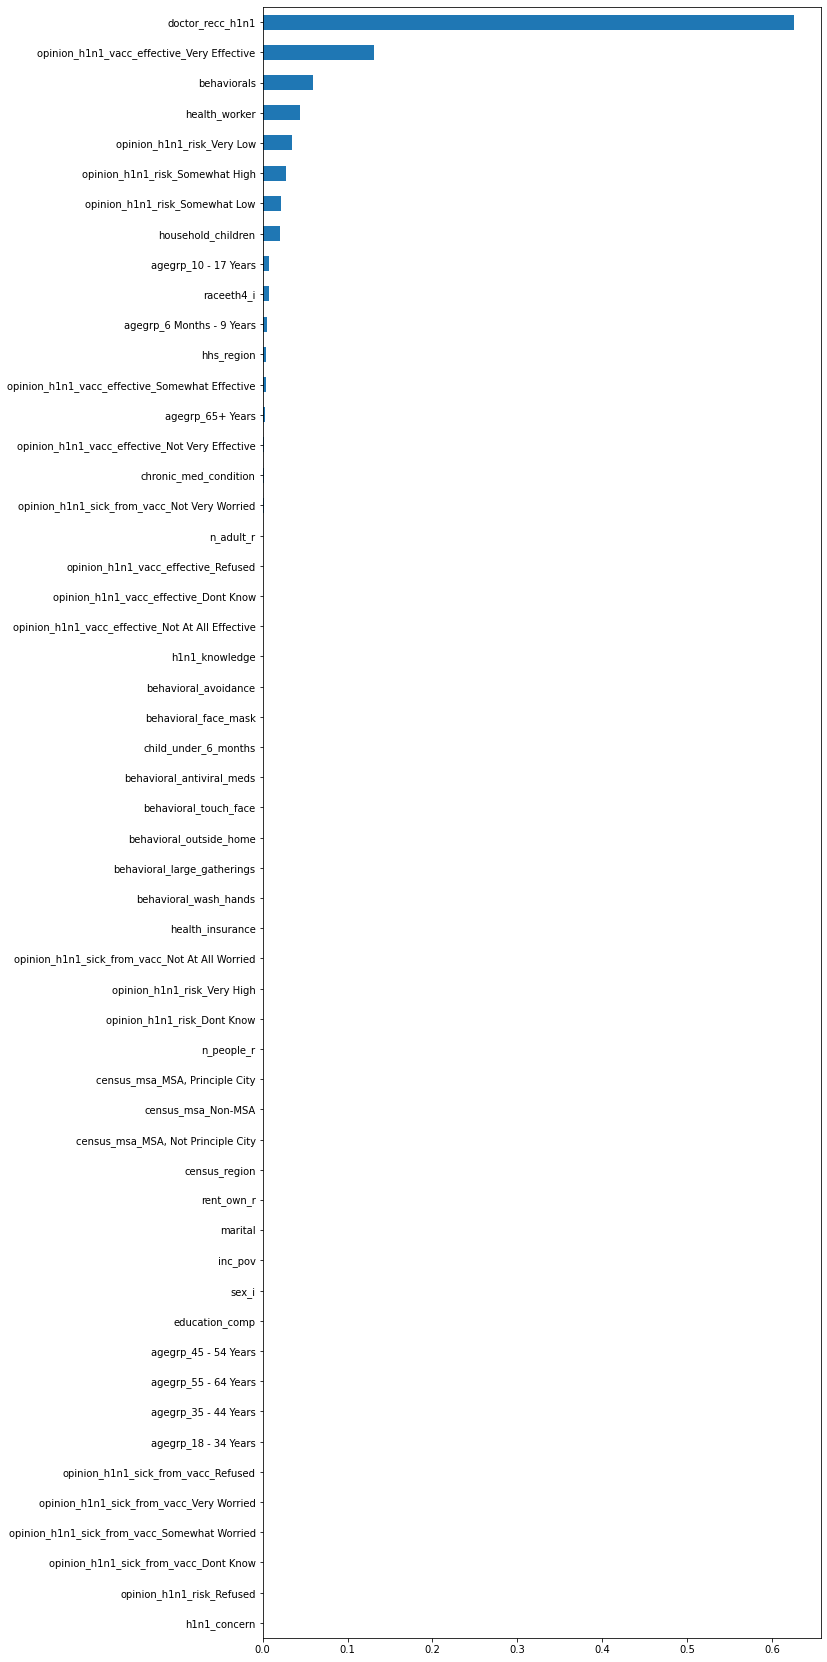

In [10]:
import matplotlib.pyplot as plt

%matplotlib inline

model_dt = pipe.named_steps['decisiontreeclassifier']
enc = pipe.named_steps['onehotencoder']
encoded_columns = enc.transform(X_val).columns # 학습된 pipe 모델의 OneHotEncoder를 X_val 에 적용한 칼럼 목록

importances = pd.Series(model_dt.feature_importances_, encoded_columns) # 학습된 pipe 모델의 DecisionTreeClassifier의 특성 중요도와 위에서 구한 칼럼으로 데이터 생성
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh();

In [11]:
from sklearn.metrics import f1_score

pred_val = pipe.predict(X_val)
f1 = f1_score(y_val, pred_val)
print('f1 score :', f1)

f1 score : 0.5596280087527352


In [22]:
pred_test = pd.DataFrame(pipe.predict(X_test),columns=[target])
pred_test.reset_index(inplace=True)
pred_test.columns=['ID',target]
pred_test.set_index("ID",inplace=True)
pred_test

,vacc_h1n1_f
ID,
0,0
1,0
2,0
3,0
4,0
...,...
28099,0
28100,0
28101,0


In [17]:
pred_test.to_csv('/content/drive/MyDrive/Colab Notebooks/prediction-of-h1n1-vaccination/test_pred.csv')

### 4) 테스트셋 예측 결과 제출(Submission)

- 테스트셋에 대한 예측 결과를 캐글에 제출 하세요.(스코어가 많이 낮게 나와도 결정트리를 잘 이해하고 결과를 내었다면 충분합니다!)
- **(Urclass Quiz) 캐글 Leaderboard의 본인 Score를 제출하세요.**
 

## 🔥 도전과제(Github - Discussion)

### 4) 2개 이상의 imputer를 사용해 각각 특성-타겟 관계 그래프를 그려 공유하고 다음 질문에 대해 서로 논의해 보세요. 
- scikit-learn imputer([scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html))
- seaborn plots 사용하여 관심있는 특성들과 target간의 관계를 그래프로 나타내 보세요.
- 사용하신 imputer는 각각 어떤 장단점을 갖고 있으며 어떤 상황에서 사용하면 좋을까요? 
- 만드신 특성-타겟 관계 그래프에서 차이점이 있다면 무엇이고, 왜 그런 차이가 발생했다고 생각하시나요? 
- [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html)
- [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html)

In [15]:
### 이곳에서 과제를 진행해 주세요 ###